# Import

In [1]:
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import itertools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, CCA, PLSSVD
import pandas as pd
import pymannkendall as mk
import seaborn as sns
from scipy.stats import gaussian_kde
from xmca.xarray import xMCA
from scipy.stats import linregress
from collections import defaultdict
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from scipy.signal import detrend as scipy_detrend
from sklearn.linear_model import LinearRegression
import regionmask
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import clone
from sklearn.metrics import make_scorer
import os
import statsmodels.api as sm
import subprocess

# Load

In [2]:
import os
if not os.path.exists('download'):
    os.makedirs('download')
if not os.path.exists('data'):
    os.makedirs('data')

download = False

In [3]:
cfsv2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES_FULL/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cfsv2_path = 'download/cfsv2_precip.nc'

gfdlspear_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
gfdlspear_path = 'download/gfdlspear_precip.nc'

cansipsic4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC4/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cansipsic4_path = 'download/cansipsic4_precip.nc'

cesm1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CESM1/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cesm1_path = 'download/cesm1_precip.nc'

colaccsm4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
colaccsm4_path = 'download/colaccsm4_precip.nc'

nasageos1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos1_path = 'download/nasageos1_precip.nc'
nasageos2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos2_path = 'download/nasageos2_precip.nc'

if download:
    print(cfsv2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cfsv2_url, '-o', cfsv2_path])
    print(gfdlspear_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', gfdlspear_url, '-o', gfdlspear_path])
    print(cesm1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cesm1_url, '-o', cesm1_path])
    print(colaccsm4_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', colaccsm4_url, '-o', colaccsm4_path])
    print(nasageos1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos1_url, '-o', nasageos1_path])
    print(nasageos2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos2_url, '-o', nasageos2_path])
    #print(cansipsic4_url)
    #subprocess.call(['curl', '-b', 'cookies.txt', '-k', cansipsic4_url, '-o', cansipsic4_path])
    
cfsv2 = xr.open_dataset(cfsv2_path, decode_times=True)
gfdlspear = xr.open_dataset(gfdlspear_path, decode_times=True)
cesm1 = xr.open_dataset(cesm1_path, decode_times=True)
colaccsm4 = xr.open_dataset(colaccsm4_path, decode_times=True)
nasageos = xr.open_dataset(nasageos1_path, decode_times=True)
nasageos2 = xr.open_dataset(nasageos2_path, decode_times=True).isel(M=slice(0, 4))
#concatenate the two nasageos datasets
nasageos = xr.concat([nasageos, nasageos2], dim='S')
#cansipsic4 = xr.open_dataset(cansipsic4_path, decode_times=True)

# Take member-mean for each model
cfsv2_mean      = cfsv2["prec"].mean(dim="M")
gfdlspear_mean  = gfdlspear["prec"].mean(dim="M")
cesm1_mean      = cesm1["prec"].mean(dim="M")
colaccsm4_mean  = colaccsm4["prec"].mean(dim="M")
nasageos_mean   = nasageos["prec"].mean(dim="M")

#  Multi-model ensemble mean
spi = xr.concat(
    [
        cfsv2_mean,
        gfdlspear_mean,
        cesm1_mean,
        colaccsm4_mean,
        nasageos_mean
    ],
    dim="model"
).mean(dim="model")

spi = spi.sel(L=2.5)
spi = spi.rename({"Y": "lat", "X": "lon", "S": "time"})

mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(
    spi['lon'], spi['lat']
)

spi_3m = spi + spi.shift(time =-1) + spi.shift(time=-2)
spi = spi_3m.sel(time=spi['time'][2:]) /3
#time is 1991-2020
spi = spi.sel(time=slice('1991-01-01', '2020-12-31'))

# Fig1 - Trend

In [4]:
def mk_test(x):
    x = x[~np.isnan(x)]
    if len(x) < 3:
        return np.array([np.nan, np.nan])
    result = mk.original_test(x)
    trend_value = result.slope  # numeric trend (Sen's slope)
    sig = int(result.p <= 0.05)
    return np.array([trend_value, sig])

In [5]:
month_to_season = {
    1: 'NDJ', 2: 'DJF', 3: 'JFM', 4: 'FMA',
    5: 'MAM', 6: 'AMJ', 7: 'MJJ', 8: 'JJA',
    9: 'JAS', 10: 'ASO', 11: 'SON', 12: 'OND'
}


In [6]:
months = np.arange(1, 13)
season_labels = [month_to_season[m] for m in months]

trend_list = []
sig_list = []

for month in months:
    print(f"Processing month {month} : {month_to_season[month]}")
    
    spi_month = spi.sel(time=spi['time'].dt.month == month)
    
    trend_sig = xr.apply_ufunc(
        mk_test,
        spi_month,
        input_core_dims=[['time']],
        output_core_dims=[['metric']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    
    trend = trend_sig.sel(metric=0)
    sig = trend_sig.sel(metric=1)
    
    trend_list.append(trend)
    sig_list.append(sig)


Processing month 1 : NDJ
Processing month 2 : DJF
Processing month 3 : JFM
Processing month 4 : FMA
Processing month 5 : MAM
Processing month 6 : AMJ
Processing month 7 : MJJ
Processing month 8 : JJA
Processing month 9 : JAS
Processing month 10 : ASO
Processing month 11 : SON
Processing month 12 : OND


In [7]:
trend_seasonal = xr.concat(trend_list, dim='season')
sig_seasonal = xr.concat(sig_list, dim='season')
trend_seasonal['season'] = season_labels
sig_seasonal['season'] = season_labels

selected_seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
trend_subset = trend_seasonal.sel(season=selected_seasons)
sig_subset = sig_seasonal.sel(season=selected_seasons)


C:\Users\emile\AppData\Local\Temp\ipykernel_16684\1075421618.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  brbg = cm.get_cmap('BrBG', 256)
C:\Users\emile\AppData\Local\Temp\ipykernel_16684\1075421618.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  brbg = cm.get_cmap('BrBG', 256)
C:\Users\emile\AppData\Local\Temp\ipykernel_16684\1075421618.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  brbg = cm.get_cmap('BrBG', 256)
C:\Users\emile\AppData\Local

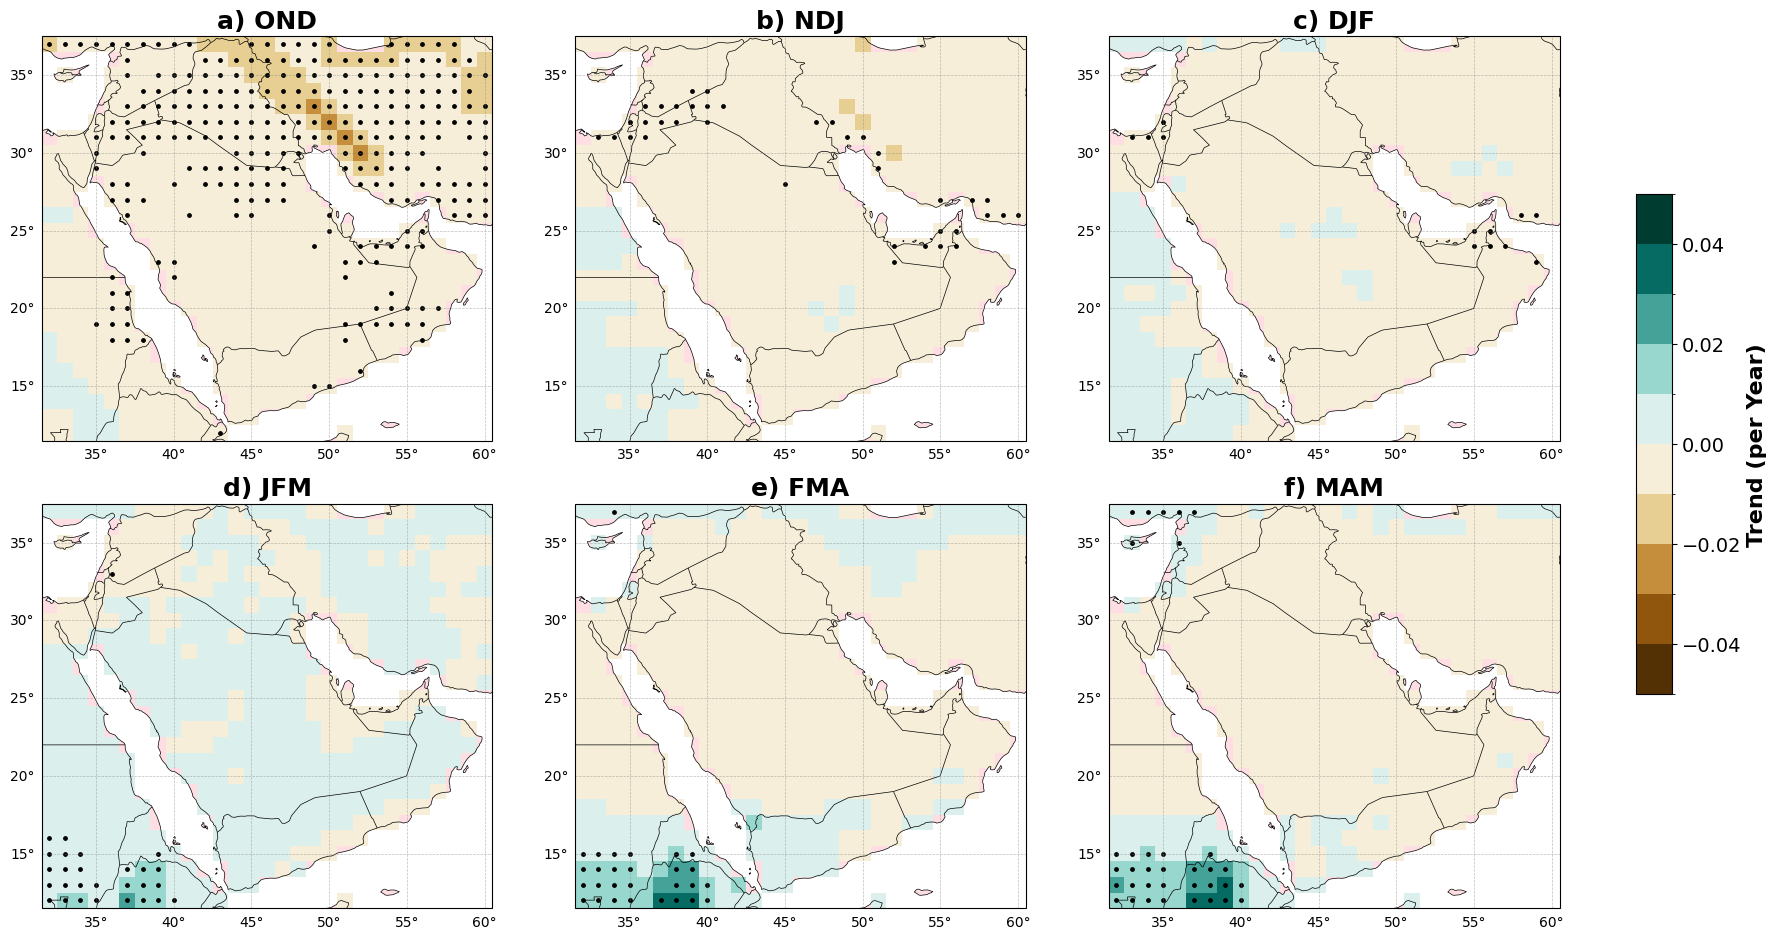

In [8]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10),
                         subplot_kw={'projection': ccrs.PlateCarree()})

axes = axes.flatten()

# Labels to prefix the season titles
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for i, ax in enumerate(axes):
    if i < len(selected_seasons):
        season = selected_seasons[i]
        tr = trend_subset.sel(season=season)
        tr = tr.where(mask == 0, np.nan)
        sig = sig_subset.sel(season=season)
        brbg = cm.get_cmap('BrBG', 256)
        brbg = mcolors.ListedColormap(brbg(np.linspace(0, 1, 256)))
        #brbg.set_under('white')

        pcm = tr.plot.pcolormesh(
            ax=ax,
            cmap=brbg,
            vmin=-0.05, vmax=0.05, levels=11,
            add_colorbar=False,
            transform=ccrs.PlateCarree()
        )

        y_coords, x_coords = np.where((sig.values == 1) & (mask == 0))
        lats = tr['lat'].values[y_coords]
        lons = tr['lon'].values[x_coords]
        ax.scatter(lons, lats, color='k', s=6, transform=ccrs.PlateCarree())

        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.LAND, facecolor="lightpink", alpha=0.45)

        # Add a), b), etc. before the season name
        ax.set_title(f"{labels[i]} {season}", fontsize=18, fontweight='bold')

        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),
                          linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = True
        gl.bottom_labels = True

        gl.xformatter = mticker.FuncFormatter(lambda x, pos: f"{int(x)}°")
        gl.yformatter = mticker.FuncFormatter(lambda y, pos: f"{int(y)}°")

    else:
        ax.axis('off')

# Add a larger colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
cbar = fig.colorbar(pcm, cax=cbar_ax, label='Trend (per Year)', orientation='vertical')
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.label.set_size(16)
cbar.ax.yaxis.label.set_weight('bold')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig('fig1_trend_MODEL.pdf', dpi=300)
plt.show()
